In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from datetime import datetime
import scipy.stats
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,f1_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet,BayesianRidge
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import sqlite3

In [2]:
import io
df = pd.read_csv('Walmart.csv')
%load_ext sql
conn = sqlite3.connect('Walmart.db')  # Change to your desired database name
df.to_sql('data', conn, index=False, if_exists='replace')  # Change 'your_table_name' to your desired table name
%sql sqlite:///Walmart.db

# Execute an SQL query using magic command
%sql SELECT * FROM data limit 5;

 * sqlite:///Walmart.db
Done.


[(1, '05-02-2010', 1643690.9, 0, 42.31, 2.572, 211.0963582, 8.106),
 (1, '12-02-2010', 1641957.44, 1, 38.51, 2.548, 211.2421698, 8.106),
 (1, '19-02-2010', 1611968.17, 0, 39.93, 2.514, 211.2891429, 8.106),
 (1, '26-02-2010', 1409727.59, 0, 46.63, 2.561, 211.3196429, 8.106),
 (1, '05-03-2010', 1554806.68, 0, 46.5, 2.625, 211.3501429, 8.106)]

In [3]:
# THERE ARE 2 CATEGORICAL COLUMNS AND 6 NON CATEGORICAL COLUMNS
# STORE AND HOLIDAYS

#%sql UPDATE data SET Date = strftime('%Y-%m-%d', Date);
%sql PRAGMA table_info(data);


 * sqlite:///Walmart.db
Done.


[(0, 'Store', 'INTEGER', 0, None, 0),
 (1, 'Date', 'TEXT', 0, None, 0),
 (2, 'Weekly_Sales', 'REAL', 0, None, 0),
 (3, 'Holiday_Flag', 'INTEGER', 0, None, 0),
 (4, 'Temperature', 'REAL', 0, None, 0),
 (5, 'Fuel_Price', 'REAL', 0, None, 0),
 (6, 'CPI', 'REAL', 0, None, 0),
 (7, 'Unemployment', 'REAL', 0, None, 0)]

In [4]:
%sql select min(Weekly_Sales),min(Temperature	),min(Fuel_Price),min(CPI),min(Unemployment) from data  


 * sqlite:///Walmart.db
Done.


[(209986.25, -2.06, 2.472, 126.064, 3.879)]

In [5]:
%sql select max(Weekly_Sales),max(Temperature	),max(Fuel_Price),max(CPI),max(Unemployment) from data 


 * sqlite:///Walmart.db
Done.


[(3818686.45, 100.14, 4.468, 227.2328068, 14.313)]

In [6]:
%sql select round(avg(Weekly_Sales),2),round(avg(Temperature),2),round(avg(Fuel_Price),2),round(avg(CPI),2),round(avg(Unemployment),2) from data 


 * sqlite:///Walmart.db
Done.


[(1046964.88, 60.66, 3.36, 171.58, 8.0)]

In [7]:
%sql select count(Weekly_Sales),count(Temperature	),count(Fuel_Price),count(CPI),count(Unemployment) from data 


 * sqlite:///Walmart.db
Done.


[(6435, 6435, 6435, 6435, 6435)]

In [8]:
fig, axs = plt.subplots(3,2, figsize=(15,15))
axs[0,0].boxplot(df['Weekly_Sales'])
axs[0,0].set_title('Weekly Sales')
axs[0,1].boxplot(df['Temperature'])
axs[0,1].set_title('Temperature')
axs[1,0].boxplot(df['Fuel_Price'])
axs[1,0].set_title('Fuel_Price')
axs[1,1].boxplot(df['CPI'])
axs[1,1].set_title('CPI')
axs[2,0].boxplot(df['Unemployment'])
axs[2,0].set_title('Unemployment')

Text(0.5, 1.0, 'Unemployment')

In [9]:
# REPLACING OUTLIERS OF TEMPERATURE WITH AVERAGE (BEFORE AND AFTER VALUE)
Q1,Q3= df['Temperature'].quantile(0.25),df['Temperature'].quantile(0.75),
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
for i in df['Temperature']:
    if i>upper_bound or i<lower_bound:
        id1=df[df['Temperature']==i][:1].index-1
        id2=df[df['Temperature']==i][:1].index+1
        before_value=df.iloc[id1]['Temperature'].values[0]
        after_value=df.iloc[id2]['Temperature'].values[0]
        df['Temperature'].replace(i,(before_value+after_value)/2,inplace=True)

In [10]:
# REPLACINNG OUTLIERS OF EMPLOYEMENT WITH MEAN
Q1,Q3= df['Unemployment'].quantile(0.25),df['Unemployment'].quantile(0.75),
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
for i in df['Unemployment']:
    if i>upper_bound or i<lower_bound:
        df['Unemployment'].replace(i,df['Unemployment'].mean(),inplace=True)

In [11]:
sns.distplot(df['Unemployment'],fit=norm,bins=10);
print('skewness of unemployement',skew(df['Unemployment']))
(mean,standard_deviation) = norm.fit(df['Unemployment'])
print('mean is',mean,'and standard deviation is',standard_deviation)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, standard_deviation)],
            loc = 'best')
plt.title('Unemployement distribution (Original)')
## UNEMPLOYEMENT IS CLOSE TO NORMAL DISTRIBUTION
## SO WE CAN USE MEAN AS OUTLIER REPLACEMENT

skewness of unemployement -0.12416247265866173
mean is 7.728662872620826 and standard deviation is 1.1958054336587187


/tmp/ipykernel_3138947/3156398395.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Unemployment'],fit=norm,bins=10);


Text(0.5, 1.0, 'Unemployement distribution (Original)')

In [12]:
df.head(1)

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010     1643690.9             0        42.31       2.572   

          CPI  Unemployment  
0  211.096358         8.106

In [13]:
# useful queries for business purposes
##Total Sales per Store:

%sql  SELECT Store, ROUND(SUM(weekly_sales),1) AS total_sales FROM data GROUP BY Store limit 10;

 * sqlite:///Walmart.db
Done.


[(1, 222402808.9),
 (2, 275382441.0),
 (3, 57586735.1),
 (4, 299543953.4),
 (5, 45475688.9),
 (6, 223756130.6),
 (7, 81598275.1),
 (8, 129951181.1),
 (9, 77789219.0),
 (10, 271617713.9)]

In [34]:
##Average Weekly Sales per Store:
%sql SELECT Store, ROUND(AVG(weekly_sales),1) AS avg_weekly_sales FROM data GROUP BY Store limit 5;

 * sqlite:///Walmart.db
Done.


[(1, 1555264.4), (2, 1925751.3), (3, 402704.4), (4, 2094713.0), (5, 318011.8)]

In [33]:
## Total Sales on Holidays vs Non-Holidays:
%sql SELECT Holiday_Flag, ROUND(SUM(weekly_sales),1) AS total_sales FROM data GROUP BY Holiday_Flag;

 * sqlite:///Walmart.db
Done.


[(0, 6231919435.6), (1, 505299551.6)]

In [32]:
##Top Selling Stores:
%sql SELECT Store, ROUND(SUM(weekly_sales),1) AS total_sales FROM data GROUP BY Store ORDER BY total_sales DESC LIMIT 5;


 * sqlite:///Walmart.db
Done.


[(20, 301397792.5),
 (4, 299543953.4),
 (14, 288999911.3),
 (13, 286517703.8),
 (2, 275382441.0)]

In [37]:
##Sales Trend Over Time:
%sql SELECT date, SUM(weekly_sales) AS total_sales FROM data GROUP BY date ORDER BY date;


 * sqlite:///Walmart.db
Done.


[('01-04-2011', 43458991.190000005),
 ('01-06-2012', 48281649.72000001),
 ('01-07-2011', 47578519.5),
 ('01-10-2010', 42239875.870000005),
 ('02-03-2012', 46861034.97),
 ('02-04-2010', 50423831.26),
 ('02-07-2010', 48917484.5),
 ('02-09-2011', 45376623.269999996),
 ('02-12-2011', 49390556.49),
 ('03-02-2012', 46085608.09),
 ('03-06-2011', 48771994.18000001),
 ('03-08-2012', 47485899.56),
 ('03-09-2010', 47194257.61),
 ('03-12-2010', 49909027.879999995),
 ('04-02-2011', 46153111.11999998),
 ('04-03-2011', 46980603.739999995),
 ('04-05-2012', 47124197.930000015),
 ('04-06-2010', 50188543.12000002),
 ('04-11-2011', 48655544.300000004),
 ('05-02-2010', 49750740.49999999),
 ('05-03-2010', 46871470.300000004),
 ('05-08-2011', 48015466.97000001),
 ('05-10-2012', 47566639.309999995),
 ('05-11-2010', 45781981.890000015),
 ('06-01-2012', 44955421.949999996),
 ('06-04-2012', 53502315.86999999),
 ('06-05-2011', 46861958.28999999),
 ('06-07-2012', 51253021.88000001),
 ('06-08-2010', 48204999.120000005),
 ('07-01-2011', 42775787.77),
 ('07-05-2010', 48503243.519999996),
 ('07-09-2012', 48330059.31),
 ('07-10-2011', 47211688.36),
 ('08-04-2011', 45887466.79999998),
 ('08-06-2012', 49651171.779999994),
 ('08-07-2011', 47859263.78),
 ('08-10-2010', 45102974.230000004),
 ('09-03-2012', 47480454.11000001),
 ('09-04-2010', 47365290.43999999),
 ('09-07-2010', 47899529.370000005),
 ('09-09-2011', 46763227.529999994),
 ('09-12-2011', 55561147.69999999),
 ('10-02-2012', 50009407.919999994),
 ('10-06-2011', 47669734.66),
 ('10-08-2012', 47403451.04000002),
 ('10-09-2010', 45634397.84),
 ('10-12-2010', 55666770.39000001),
 ('11-02-2011', 47336192.79000002),
 ('11-03-2011', 44627319.4),
 ('11-05-2012', 46925878.99000001),
 ('11-06-2010', 47826546.720000006),
 ('11-11-2011', 48474224.75000001),
 ('12-02-2010', 48336677.63000002),
 ('12-03-2010', 45925396.51),
 ('12-08-2011', 46249569.21000001),
 ('12-10-2012', 46128514.25),
 ('12-11-2010', 46124800.82999999),
 ('13-01-2012', 42023078.48000001),
 ('13-04-2012', 46629261.41),
 ('13-05-2011', 45446144.82),
 ('13-07-2012', 46099732.099999994),
 ('13-08-2010', 46464418.40999998),
 ('14-01-2011', 40673678.03999999),
 ('14-05-2010', 45330080.20000001),
 ('14-09-2012', 44226038.650000006),
 ('14-10-2011', 44374820.300000004),
 ('15-04-2011', 44973328.13999999),
 ('15-06-2012', 48412110.699999996),
 ('15-07-2011', 45515929.919999994),
 ('15-10-2010', 43149473.45),
 ('16-03-2012', 46901504.940000005),
 ('16-04-2010', 45183667.080000006),
 ('16-07-2010', 46243899.58000001),
 ('16-09-2011', 43793960.08000001),
 ('16-12-2011', 60085695.939999975),
 ('17-02-2012', 50197056.95999998),
 ('17-06-2011', 47447561.77000002),
 ('17-08-2012', 47354452.049999975),
 ('17-09-2010', 43080726.51),
 ('17-12-2010', 61820799.85000001),
 ('18-02-2011', 48716164.120000005),
 ('18-03-2011', 44872325.97),
 ('18-05-2012', 46823939.22000001),
 ('18-06-2010', 47622046.230000004),
 ('18-11-2011', 46438980.56000002),
 ('19-02-2010', 48276993.779999994),
 ('19-03-2010', 44988974.640000015),
 ('19-08-2011', 46917347.61999999),
 ('19-10-2012', 45122410.57),
 ('19-11-2010', 45125584.18000001),
 ('20-01-2012', 42080996.56),
 ('20-04-2012', 45072529.779999994),
 ('20-05-2011', 44046598.00999999),
 ('20-07-2012', 46059543.449999996),
 ('20-08-2010', 47060952.919999994),
 ('21-01-2011', 40654648.02999999),
 ('21-05-2010', 45120108.059999995),
 ('21-09-2012', 44354547.11),
 ('21-10-2011', 45818953.44),
 ('22-04-2011', 48676692.05999998),
 ('22-06-2012', 47668284.96999999),
 ('22-07-2011', 45274411.38999999),
 ('22-10-2010', 43066669.51999999),
 ('23-03-2012', 44993794.449999996),
 ('23-04-2010', 44734452.56000001),
 ('23-07-2010', 44888849.10999999),
 ('23-09-2011', 42718096.730000004),
 ('23-12-2011', 76998241.31),
 ('24-02-2012', 45771506.57),
 ('24-06-2011', 45884094.58),
 ('24-08-2012', 47447323.6),
 ('24-09-2010', 41358514.410000004),
 ('24-12-2010', 80931415.60000001),
 ('25-02-2011', 44125859.84),
 ('25-03-2011', 42876199.18000001),
 ('25-05-20

In [39]:
##Impact of Temperature on Sales:
%sql SELECT temperature, AVG(weekly_sales) AS avg_weekly_sales FROM data GROUP BY temperature;


 * sqlite:///Walmart.db
Done.


[(-2.06, 558027.77),
 (5.54, 817485.14),
 (6.23, 1083071.14),
 (7.46, 593875.46),
 (9.51, 775910.43),
 (9.55, 1034119.21),
 (10.09, 661163.94),
 (10.11, 513372.17),
 (10.24, 559903.13),
 (10.53, 496725.44),
 (10.91, 1083657.61),
 (11.17, 782826.235),
 (11.29, 816603.05),
 (11.32, 547384.9),
 (12.19, 1059715.27),
 (12.39, 573545.96),
 (12.98, 809833.21),
 (13.29, 904261.65),
 (13.64, 479263.15),
 (13.76, 729572.08),
 (14.02, 811365.42),
 (14.19, 813211.46),
 (14.31, 945643.17),
 (14.44, 574798.86),
 (14.48, 1001943.8),
 (14.5, 1159438.53),
 (14.56, 1179420.5),
 (14.64, 764014.75),
 (14.84, 849540.85),
 (15.02, 466806.89),
 (15.12, 1010711.08),
 (15.2, 720242.19),
 (15.22, 838751.5),
 (15.25, 1364721.58),
 (15.33, 1146992.13),
 (15.47, 1070457.8),
 (15.56, 815915.52),
 (15.58, 1110706.06),
 (15.64, 749549.55),
 (16.3, 910298.44),
 (16.5, 888869.27),
 (16.57, 758510.36),
 (16.6, 1149612.04),
 (16.7, 812323.29),
 (16.81, 1150003.36),
 (16.87, 931939.52),
 (16.94, 1016432.385),
 (17.0, 1206917.2),
 (17.05, 1548661.45),
 (17.3, 572387.47),
 (17.46, 508528.21499999997),
 (17.56, 976522.93),
 (17.91, 1126921.34),
 (17.94, 1415746.91),
 (17.95, 835189.26),
 (18.12, 443242.17),
 (18.14, 1015684.09),
 (18.2, 1016756.1),
 (18.3, 572360.83),
 (18.36, 841951.91),
 (18.49, 977070.62),
 (18.51, 1124357.2),
 (18.55, 771315.62),
 (18.67, 713117.66),
 (18.73, 877268.29),
 (18.75, 1144872.615),
 (18.76, 1289156.9),
 (18.79, 563460.77),
 (18.8, 972834.42),
 (18.92, 600448.69),
 (19.03, 1005448.76),
 (19.05, 1169773.85),
 (19.29, 811318.3),
 (19.53, 517719.895),
 (19.55, 508520.09),
 (19.61, 481119.6),
 (19.63, 981978.02),
 (19.64, 583364.02),
 (19.66, 575317.38),
 (19.79, 477409.3),
 (19.83, 652122.44),
 (20.12, 1872365.99),
 (20.28, 873576.96),
 (20.38, 591907.88),
 (20.39, 1884345.01),
 (20.6, 987587.835),
 (20.61, 802203.15),
 (20.66, 1284185.49),
 (20.67, 1301185.28),
 (20.69, 556550.85),
 (20.7, 558963.83),
 (20.74, 716388.81),
 (20.79, 880798.5833333334),
 (20.8, 448391.99),
 (20.84, 955338.29),
 (20.87, 509804.185),
 (20.96, 1507637.17),
 (21.02, 1370562.11),
 (21.07, 1067754.06),
 (21.1, 677231.63),
 (21.13, 704008.955),
 (21.18, 615666.78),
 (21.33, 1205307.5),
 (21.39, 492721.85),
 (21.52, 1249786.4),
 (21.6, 1047707.59),
 (21.64, 748379.4),
 (21.68, 1181204.53),
 (21.69, 1028206.51),
 (21.79, 1430851.11),
 (21.81, 1573982.47),
 (21.82, 968694.45),
 (21.84, 676877.0499999999),
 (21.88, 552811.62),
 (22.0, 960645.8300000001),
 (22.12, 1308346.095),
 (22.16, 736335.69),
 (22.2, 580453.32),
 (22.3, 1213486.95),
 (22.41, 1167740.2),
 (22.43, 1388725.63),
 (22.44, 1052609.16),
 (22.47, 926573.81),
 (22.49, 955641.74),
 (22.5, 679481.9),
 (22.52, 1330451.46),
 (22.53, 1515175.01),
 (22.55, 891148.55),
 (22.62, 999348.55),
 (22.65, 964729.18),
 (22.69, 777175.28),
 (22.8, 1212967.84),
 (22.91, 770157.29),
 (22.94, 1133474.405),
 (22.96, 2734277.1),
 (22.99, 857899.075),
 (23.01, 1179036.3),
 (23.04, 1075656.34),
 (23.05, 2238573.48),
 (23.11, 789036.02),
 (23.21, 1164800.125),
 (23.22, 1536549.95),
 (23.24, 1296658.47),
 (23.29, 954576.86),
 (23.33, 514731.6),
 (23.34, 1129422.86),
 (23.35, 1071069.83),
 (23.4, 464189.09),
 (23.41, 564536.01),
 (23.44, 1237104.73),
 (23.46, 651837.77),
 (23.63, 880165.7),
 (23.64, 1027200.665),
 (23.68, 512260.59),
 (23.69, 790468.6799999999),
 (23.76, 1153596.53),
 (23.78, 1046416.17),
 (23.79, 927732.02),
 (23.82, 971932.87),
 (23.83, 1225182.04),
 (23.87, 594744.89),
 (23.89, 1081005.64),
 (23.9, 965788.76),
 (23.91, 665861.06),
 (23.92, 999785.48),
 (23.94, 639830.45),
 (23.97, 847294.04),
 (24.05, 1041735.3833333333),
 (24.07, 2819193.17),
 (24.13, 1052034.74),
 (24.16, 748160.28),
 (24.18, 1648829.18),
 (24.2, 937522.77),
 (24.21, 816138.33),
 (24.24, 599730.07),
 (24.26, 1243812.59),
 (24.27, 2752122.08),
 (24.29, 1150662.55),
 (24.3, 1122053.58),
 (24.36, 779636.12),
 (24.41, 603041.14),
 (24.46, 1601585.7),
 (24.48, 944594.78),
 (24.5, 900646.94),
 (24.69, 1084243.91),
 (24.76, 1291860.1749999998),
 (2

In [40]:
#Correlation between Fuel Price and Sales:
%sql SELECT fuel_price, AVG(weekly_sales) AS avg_weekly_sales FROM data GROUP BY fuel_price;

 * sqlite:///Walmart.db
Done.


[(2.472, 470281.03),
 (2.513, 434471.38),
 (2.514, 1015099.2707142858),
 (2.52, 447519.44),
 (2.533, 431294.45),
 (2.539, 469563.7),
 (2.54, 1516911.665),
 (2.542, 452021.2),
 (2.545, 467546.74),
 (2.548, 1040743.7442857145),
 (2.55, 713183.45),
 (2.561, 891811.9746666667),
 (2.562, 412050.73),
 (2.565, 923341.2999999999),
 (2.567, 422169.47),
 (2.572, 953758.7210526317),
 (2.573, 1216787.1066666667),
 (2.574, 1092755.0666666667),
 (2.577, 956875.7157142857),
 (2.578, 419348.59),
 (2.58, 787071.0275),
 (2.582, 900999.2850000001),
 (2.584, 1450107.1600000001),
 (2.586, 746128.56),
 (2.59, 1415742.485),
 (2.594, 1392702.54),
 (2.595, 444351.61),
 (2.596, 471713.59),
 (2.598, 1545686.415),
 (2.601, 434879.87),
 (2.602, 432451.91),
 (2.603, 891191.0800000001),
 (2.604, 437949.9),
 (2.606, 434252.15),
 (2.608, 915017.5364285714),
 (2.612, 1375238.865),
 (2.615, 467711.18),
 (2.619, 969559.4358823529),
 (2.62, 766431.4075),
 (2.621, 1383130.69),
 (2.623, 939431.9642857143),
 (2.624, 863695.8242857142),
 (2.625, 979690.4785714286),
 (2.627, 990882.9964285714),
 (2.633, 931441.4114285716),
 (2.635, 1435674.195),
 (2.637, 1029874.1137499999),
 (2.64, 970666.206875),
 (2.642, 1004071.5056250002),
 (2.644, 470436.8),
 (2.645, 1441602.76),
 (2.65, 1336307.22),
 (2.653, 939981.7764285717),
 (2.654, 1238678.5985714286),
 (2.655, 405860.37),
 (2.664, 951450.9),
 (2.666, 1012449.1666666666),
 (2.667, 949792.668235294),
 (2.668, 1080704.0766666667),
 (2.669, 972768.1900000001),
 (2.671, 1228415.306),
 (2.674, 843612.18),
 (2.68, 392654.26),
 (2.681, 1002632.5833333334),
 (2.684, 810825.5725),
 (2.689, 963635.8071428569),
 (2.69, 894517.93125),
 (2.691, 865090.8425),
 (2.692, 922171.7694444443),
 (2.694, 360266.09),
 (2.698, 1127738.5666666667),
 (2.699, 1179527.2236363639),
 (2.7, 869945.5225000001),
 (2.701, 1099443.36),
 (2.704, 1407785.985),
 (2.705, 968459.850625),
 (2.706, 1215864.1400000001),
 (2.707, 1181827.196),
 (2.708, 965461.8806666669),
 (2.711, 773097.4879999999),
 (2.712, 871520.13),
 (2.713, 1142739.294),
 (2.715, 1125319.3033333335),
 (2.716, 873599.5376190478),
 (2.717, 879507.4168749999),
 (2.718, 998834.1075000002),
 (2.719, 1022535.1264285714),
 (2.72, 925892.1514285713),
 (2.723, 896473.895),
 (2.725, 831332.0954999999),
 (2.727, 1552021.19),
 (2.728, 948323.0881818183),
 (2.729, 788588.04),
 (2.731, 862238.105),
 (2.732, 944960.4764999999),
 (2.733, 958946.5299999999),
 (2.735, 1242567.1024999996),
 (2.736, 1431951.83),
 (2.737, 831505.5037500001),
 (2.74, 1479337.8900000001),
 (2.741, 1130380.25),
 (2.742, 1247086.115),
 (2.743, 1080839.03),
 (2.745, 1147216.618888889),
 (2.747, 986125.9816666668),
 (2.748, 805127.1825),
 (2.75, 771598.6675),
 (2.752, 1685556.9449999998),
 (2.753, 895724.7683333334),
 (2.754, 1276969.1080000002),
 (2.755, 1263520.196),
 (2.756, 1400201.04),
 (2.758, 816012.0525),
 (2.759, 917928.9327777778),
 (2.762, 761346.5777777778),
 (2.764, 1289346.75),
 (2.765, 742173.165),
 (2.766, 891898.4720000001),
 (2.767, 474917.98),
 (2.769, 483699.56),
 (2.77, 1014389.212),
 (2.771, 999687.0693103449),
 (2.773, 1125979.3254545454),
 (2.776, 847015.5385714287),
 (2.777, 1392614.0040000002),
 (2.778, 1137680.4),
 (2.779, 1299860.094),
 (2.78, 1046014.5135999998),
 (2.781, 1419212.2999999998),
 (2.782, 967151.2033333335),
 (2.783, 1347452.226),
 (2.784, 1270042.5931250001),
 (2.786, 489372.02),
 (2.787, 1338597.7349999999),
 (2.788, 914794.197),
 (2.791, 1035307.4700000001),
 (2.792, 1011130.4591666665),
 (2.793, 1144069.7666666666),
 (2.795, 922378.54),
 (2.796, 1007244.52),
 (2.797, 1003326.935),
 (2.8, 791647.8300000001),
 (2.802, 1008243.285),
 (2.805, 1099269.156),
 (2.806, 1070939.72),
 (2.808, 1062700.004736842),
 (2.809, 1408466.902),
 (2.81, 1061689.5535714284),
 (2.812, 1091389.2733333334),
 (2.813, 404545.03),
 (2.814, 1092606.09),
 (2.815, 1268968.8209090908),
 (2.817, 1234065.7266666668),
 (2.818, 1348732.34),
 (2.819, 1021064.3416666667),
 (2.82, 1193990.37),
 (2.825, 951225.2566666668),
 (2.826

In [14]:
##Sales Performance during Holidays:
%sql SELECT Holiday_Flag, AVG(weekly_sales) AS avg_weekly_sales FROM data GROUP BY Holiday_Flag;

 * sqlite:///Walmart.db
Done.


[(0, 1041256.3802088564), (1, 1122887.8923555554)]

In [16]:
#Average Sales with and without Holidays:
%sql SELECT Holiday_Flag, AVG(weekly_sales) AS avg_weekly_sales FROM data GROUP BY Holiday_Flag;


 * sqlite:///Walmart.db
Done.


[(0, 1041256.3802088564), (1, 1122887.8923555554)]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness of Weekly_Sales 0.6682059921068103
mean is 1046964.8775617715 and standard deviation is 564322.7690195543


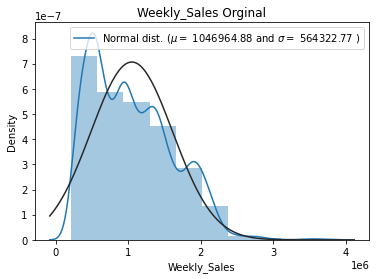

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness of Temperature -0.331824636250604
mean is 60.66863403263403 and standard deviation is 18.429745952904533


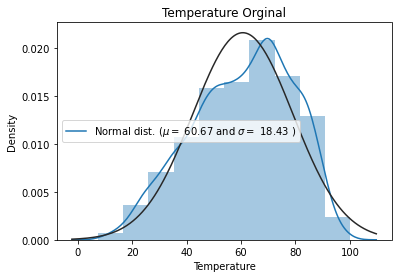

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness of Fuel_Price -0.09613588414498364
mean is 3.358606837606838 and standard deviation is 0.4589840399402098


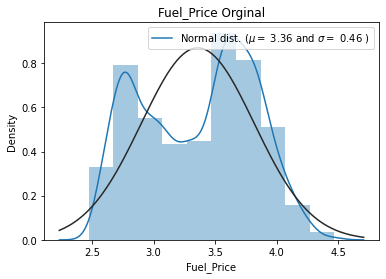

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness of CPI 0.06347704896208373
mean is 171.57839384878014 and standard deviation is 39.35365415724738


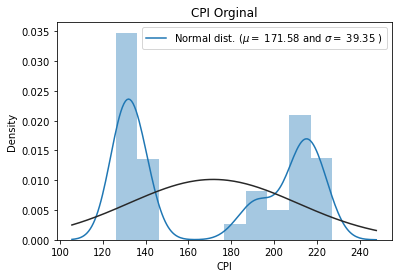

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


skewness of Unemployment -0.12416247265866173
mean is 7.728662872620826 and standard deviation is 1.1958054336587187


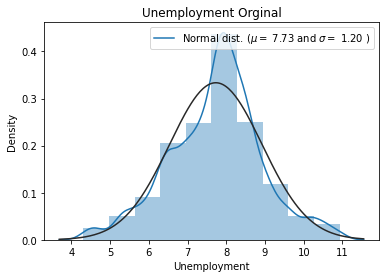

In [ ]:
## CHECKING SKEWNESS
cols=['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']
for i in cols:
    sns.distplot(df[i],bins=10,fit=norm);
    print(f'skewness of {i}',skew(df[i]))
    (mean,standard_deviation) = norm.fit(df[i])
    print('mean is',mean,'and standard deviation is',standard_deviation)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mean, standard_deviation)],
                loc = 'best')
    plt.title(f'{i} Orginal')
    plt.show()

Text(0.5, 1.0, 'Unemployment')

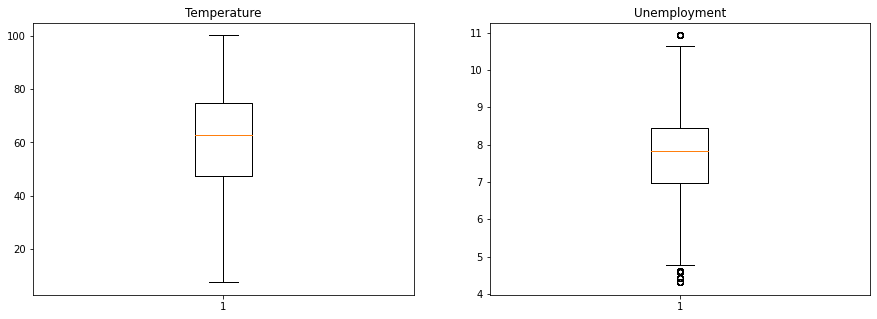

In [ ]:
# REMOVED MOST OF THE OUTLIERS FROM TEMPERATURE AND UNEMPLOYMENT 
fig, (ax1, ax2)  = plt.subplots(1, 2,figsize=(15,5))
ax1.boxplot(df['Temperature'])
ax1.set_title('Temperature')
ax2.boxplot(df['Unemployment'])
ax2.set_title('Unemployment')
#NO OUTLIERS

In [ ]:
## EXPLORATION
#figure(figsize=(15,5), dpi=80)
Total_holiday_sales=df[df['Holiday_Flag']==1]['Weekly_Sales'].mean()
Total_non_holiday_sales=df[df['Holiday_Flag']==0]['Weekly_Sales'].mean()

In [ ]:
data = {'Avg Weekly Holiday sales':Total_holiday_sales, 'Avg_non_weekly_holiday_sales':Total_non_holiday_sales}

Text(0.5, 1.0, 'Holiday vs Non Holiday (Average)')

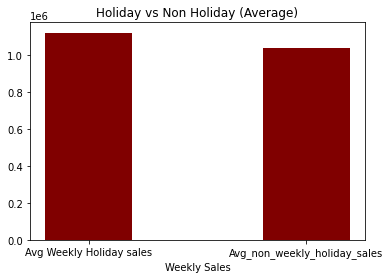

In [ ]:
plt.bar(list(data.keys()), list(data.values()), color ='maroon',
        width = 0.4)
plt.xlabel('Weekly Sales')
plt.title('Holiday vs Non Holiday (Average)')
# The holiday weeks has more sales compared to non-weekly

Text(0.5, 1.0, 'Store number vs weekly sales')

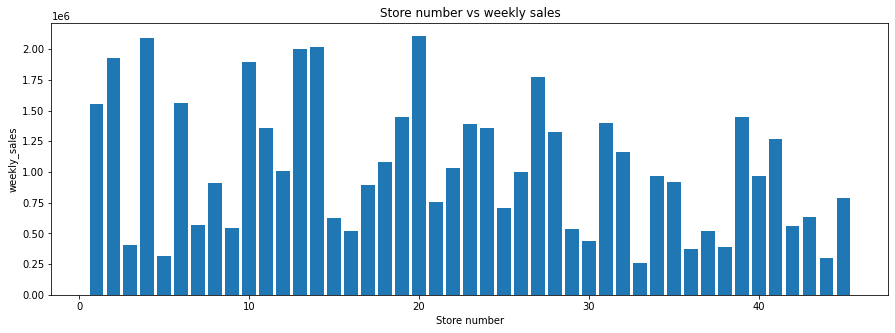

In [ ]:
store_sales=[]
store_no=[]
for i in df['Store'].unique():
    store_sales.append(df[df['Store']==i]['Weekly_Sales'].mean())
    store_no.append(i)
fig, ax1 = plt.subplots(1,1, figsize=(15,5))

plt.bar(store_no,store_sales)
plt.xlabel('Store number')
plt.ylabel('weekly_sales')
plt.title('Store number vs weekly sales')

Text(0.5, 1.0, 'Store-Wise sales')

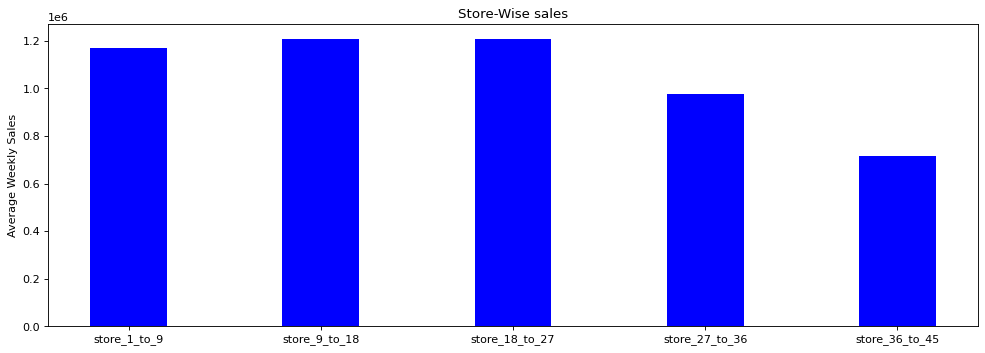

In [ ]:
store_1_to_9=[]
for i in range(1,9):
    mean_value_1to9=0
    mean_value_1to9=df[df['Store']==i]['Weekly_Sales'].mean()
    store_1_to_9.append(mean_value_1to9)
store_9_to_18=[]
for i in range(9,18):
    mean_value_9to18=0
    mean_value_9to18=df[df['Store']==i]['Weekly_Sales'].mean()
    store_9_to_18.append(mean_value_9to18)
store_18_to_27=[]
for i in range(18,27):
    mean_value_18to27=0
    mean_value_18to27=df[df['Store']==i]['Weekly_Sales'].mean()
    store_18_to_27.append(mean_value_18to27)
store_27_to_36=[]
for i in range(27,36):
    mean_value_27to36=0
    mean_value_27to36=df[df['Store']==i]['Weekly_Sales'].mean()
    store_27_to_36.append(mean_value_27to36)
store_36_to_45=[]
for i in range(36,45):
    mean_value_36to45=0
    mean_value_36to45=df[df['Store']==i]['Weekly_Sales'].mean()
    store_36_to_45.append(mean_value_36to45)
store_vis={'store_1_to_9':np.mean(store_1_to_9),
           'store_9_to_18':np.mean(store_9_to_18),
           'store_18_to_27':np.mean(store_18_to_27),
           'store_27_to_36':np.mean(store_27_to_36),
           'store_36_to_45':np.mean(store_36_to_45)}
figure(figsize=(15,5), dpi=80)
plt.bar(list(store_vis.keys()), list(store_vis.values()), color ='blue',
        width = 0.4)
plt.ylabel('Average Weekly Sales')
plt.title('Store-Wise sales')
# The stores from 27 to 36 has less sales than rest of the sales
# Thus weekly sales is somewhat dependent on stores, as the store number is between 27 to 45, the sales are less

Text(0.5, 1.0, 'weekly_sales vs Temperature')

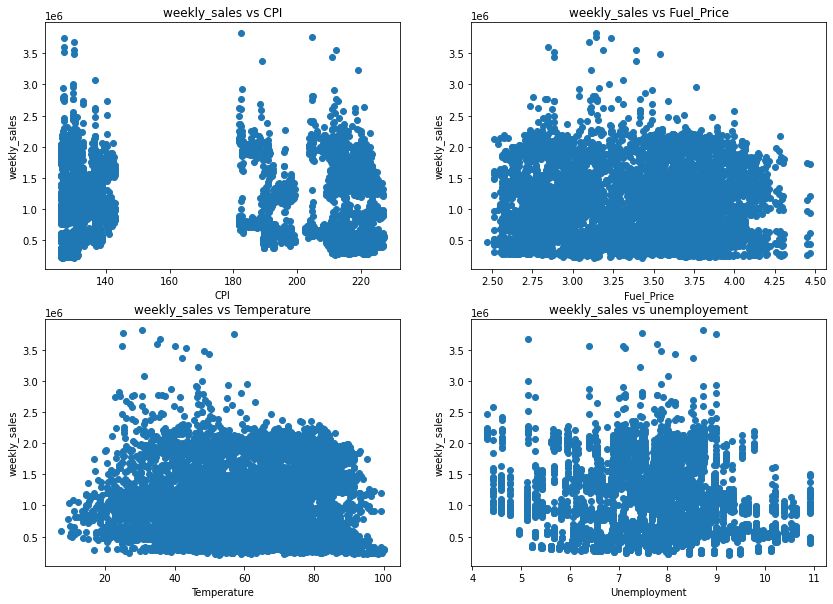

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))
axs[1,1].scatter(df[df.columns[-1]],df['Weekly_Sales'])
axs[1,1].set_xlabel('Unemployment')
axs[1,1].set_ylabel('weekly_sales')
axs[1,1].set_title('weekly_sales vs unemployement')
axs[0,0].scatter(df[df.columns[-2]],df['Weekly_Sales'])
axs[0,0].set_xlabel('CPI')
axs[0,0].set_ylabel('weekly_sales')
axs[0,0].set_title('weekly_sales vs CPI')
axs[0,1].scatter(df[df.columns[-3]],df['Weekly_Sales'])
axs[0,1].set_xlabel('Fuel_Price')
axs[0,1].set_ylabel('weekly_sales')
axs[0,1].set_title('weekly_sales vs Fuel_Price')
axs[1,0].scatter(df[df.columns[-4]],df['Weekly_Sales'])
axs[1,0].set_xlabel('Temperature')
axs[1,0].set_ylabel('weekly_sales')
axs[1,0].set_title('weekly_sales vs Temperature')
# NO SIGNIFICANT CORRELATION BETWEEN OTHER VARIABLES AND TEMPERATURE

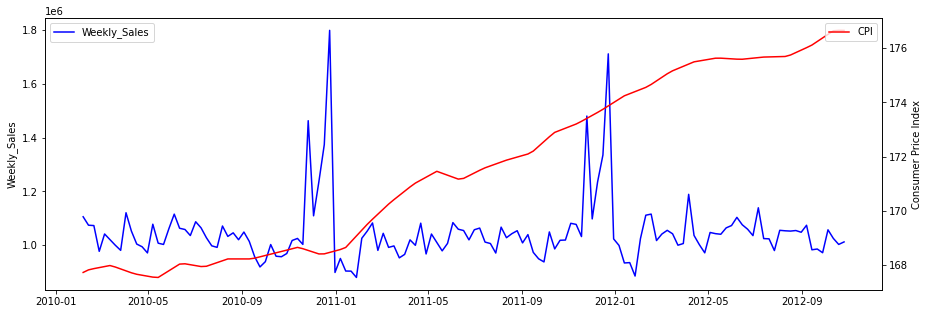

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['CPI'],color='red')
ax2.set_ylabel('Consumer Price Index')
ax2.legend(['CPI'],loc='upper right')
## THE CPI  HAS RISEN OVER THE TIME

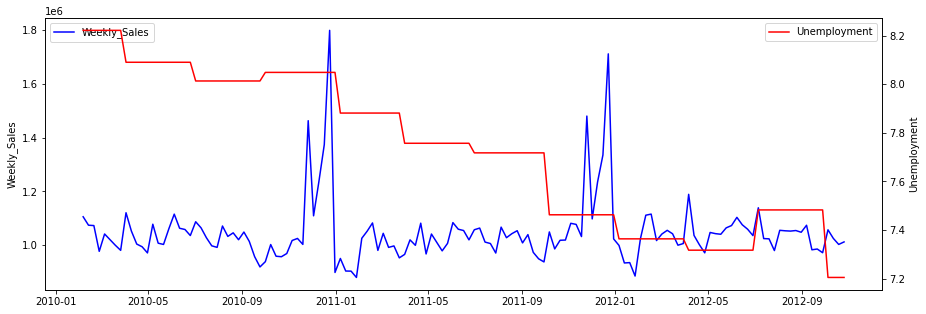

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['Unemployment'],color='red')
ax2.set_ylabel('Unemployment')
ax2.legend(['Unemployment'],loc='upper right')
## THE Unemployement  HAS decreased OVER THE TIME 


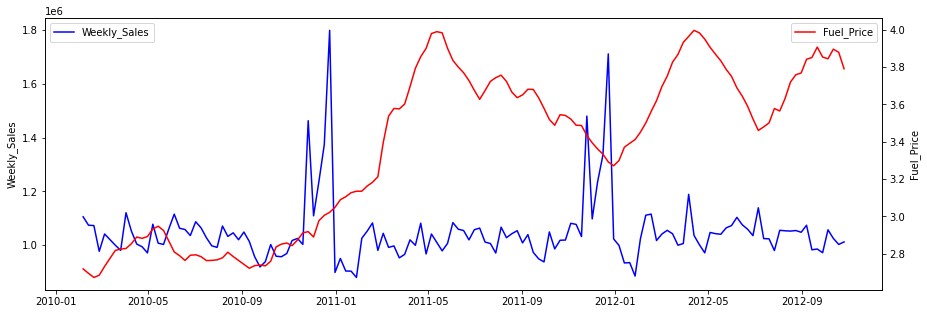

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['Fuel_Price'],color='red')
ax2.set_ylabel('Fuel_Price')
ax2.legend(['Fuel_Price'],loc='upper right')

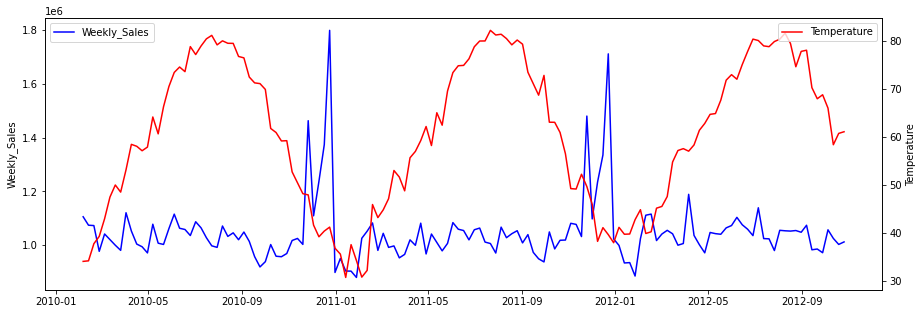

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue')
ax1.set_ylabel('Weekly_Sales')
ax1.legend(['Weekly_Sales'],loc='upper left')
ax2=ax1.twinx()
ax2.plot(df.groupby('Date').mean()['Temperature'],color='red')
ax2.set_ylabel('Temperature')
ax2.legend(['Temperature'],loc='upper right')

In [ ]:
Holidays={'SuperBowl':['2010-02','2011-02','2012-02'],
          'Labour Day':['2010-09','2011-09','2012-09'],
           'ThanksGiving':['2010-11','2011-11'],
           'Christmas':['2010-12','2011-12']}

<ipython-input-10-a69e50c7e809>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Black',linewidths=5,label='SuperBowl')
<ipython-input-10-a69e50c7e809>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Black',linewidths=5,label='SuperBowl')
<ipython-input-10-a69e50c7e809>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `fram

Text(0.5, 0, 'Time')

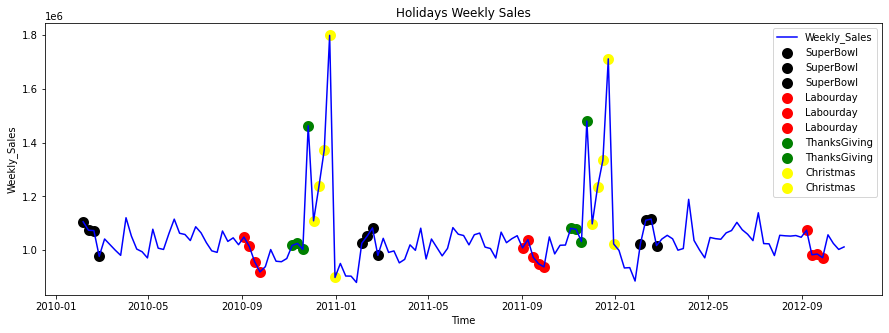

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1.plot(df.groupby('Date').mean()['Weekly_Sales'],color='blue',label='Weekly_Sales')
ax1.set_ylabel('Weekly_Sales')
for i in Holidays['SuperBowl']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Black',linewidths=5,label='SuperBowl')
for i in Holidays['Labour Day']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Red',linewidths=5,label='Labourday')
for i in Holidays['ThanksGiving']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Green',linewidths=5,label='ThanksGiving')
for i in Holidays['Christmas']:
    ax1.scatter(df.groupby('Date').mean()[i].index,df.groupby('Date').mean()[i]['Weekly_Sales'],color='Yellow',linewidths=5,label='Christmas')
ax1.legend()
ax1.set_title('Holidays Weekly Sales')
ax1.set_xlabel('Time')

In [ ]:
## THANKSGIVING AND CHRISTMAS ARE THE TWO MAJOR HOLIDAYS WHERE REVENUE SALES IS VERY MUCH HIGHER FOR WALMART
# THE NOVEMBER AND DECEMBER MONTH ARE THE MOST PROFITABLE MONTHS FOR WALMART
# upcoming months after major holiays which is january and february has lowest weekly sales for whole of walmart
# If a particualr week sees high sales because of holiay, the following week after it has lowest sales than the avg sales
# Christmas> tHANKSGIVING> LABOUR DAY> SUPER BOWL IS THE ORDER OF INCREASING WEEKLY SALES

In [7]:
df['Store'] = df.Store.astype('category')
df['Holiday_Flag'] = df.Holiday_Flag.astype('category')
target=df['Weekly_Sales']
#df1=df.drop('Weekly_Sales',axis=1)

In [8]:
def create_timefeature(df):
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['day'] = df['Date'].dt.day
    df1=df.drop('Date',axis=1)
    return df1

In [9]:
s=create_timefeature(df)
s.head()


Store  Weekly_Sales Holiday_Flag  Temperature  Fuel_Price         CPI  \
0     1    1643690.90            0        42.31       2.572  211.096358   
1     1    1641957.44            1        38.51       2.548  211.242170   
2     1    1611968.17            0        39.93       2.514  211.289143   
3     1    1409727.59            0        46.63       2.561  211.319643   
4     1    1554806.68            0        46.50       2.625  211.350143   

   Unemployment  quarter  month  dayofyear  day  
0         8.106        1      2         36    5  
1         8.106        1      2         43   12  
2         8.106        1      2         50   19  
3         8.106        1      2         57   26  
4         8.106        1      3         64    5

In [ ]:
for i in s.columns:
    a,b=scipy.stats.pearsonr(target,s[i])
    print(i,'-' ,a,' is correlation and ', b, ' is p-value')

Store - -0.33533201479281577  is correlation and  6.883078341514464e-169  is p-value
Holiday_Flag - 0.036890968010414506  is correlation and  0.00307869926384778  is p-value
Temperature - -0.06396270832132275  is correlation and  2.817671641228444e-07  is p-value
Fuel_Price - 0.009463786314475135  is correlation and  0.44782874895250047  is p-value
CPI - -0.07263416204017623  is correlation and  5.438292612224682e-09  is p-value
Unemployment - -0.0736054166739826  is correlation and  3.3924324689728825e-09  is p-value
quarter - 0.06336274735182257  is correlation and  3.6379873623058575e-07  is p-value
month - 0.07614331979236579  is correlation and  9.607838869320523e-10  is p-value
dayofyear - 0.07424819039630853  is correlation and  2.4742174621518463e-09  is p-value
day - -0.017409461859021886  is correlation and  0.16259570379093236  is p-value


In [10]:
s1=pd.get_dummies(s,drop_first=True)
s2=s1[['Temperature','Fuel_Price','CPI','Unemployment','quarter','month','dayofyear','day','Holiday_Flag_1']]
p1=StandardScaler()
new_df=pd.DataFrame(p1.fit_transform(s1),columns=s1.columns,index=s1.index)
#new_df=s1
new_df.head()

Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment   quarter  \
0      1.057420    -0.996141   -1.713800  1.004175      0.315551 -1.385591   
1      1.054348    -1.202330   -1.766089  1.007880      0.315551 -1.385591   
2      1.001206    -1.125281   -1.840166  1.009074      0.315551 -1.385591   
3      0.642828    -0.761738   -1.737766  1.009849      0.315551 -1.385591   
4      0.899914    -0.768792   -1.598328  1.010624      0.315551 -1.385591   

      month  dayofyear       day   Store_2  ...  Store_37  Store_38  Store_39  \
0 -1.373525  -1.461583 -1.219669 -0.150756  ... -0.150756 -0.150756 -0.150756   
1 -1.373525  -1.390908 -0.420135 -0.150756  ... -0.150756 -0.150756 -0.150756   
2 -1.373525  -1.320233  0.379399 -0.150756  ... -0.150756 -0.150756 -0.150756   
3 -1.373525  -1.249558  1.178933 -0.150756  ... -0.150756 -0.150756 -0.150756   
4 -1.064698  -1.178883 -1.219669 -0.150756  ... -0.150756 -0.150756 -0.150756   

   Store_40  Store_41  Store_42  Store_43  Store_44  Store_45  Holiday_Flag_1  
0 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756       -0.274204  
1 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756        3.646917  
2 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756       -0.274204  
3 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756       -0.274204  
4 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756       -0.274204  

[5 rows x 54 columns]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(new_df[new_df.columns[1:]], new_df[['Weekly_Sales']], test_size=0.2, random_state=42)

In [ ]:
# LINEAR REGRESSION
dic={'std scaler':StandardScaler(),'min-max scaler':MinMaxScaler()}
for i in dic.values():
    pipeline=make_pipeline( i,LinearRegression())
    pipeline.fit(X_train,y_train)
    print(f'Score of model with {i} is ',round(r2_score(y_test,pipeline.predict(X_test)),4))
pipelinLr=make_pipeline(LinearRegression())
pipelinLr.fit(X_train,y_train)

Score of model with StandardScaler() is  0.9268
Score of model with MinMaxScaler() is  0.9268


Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
# RIDGE REGRESSION
pipeline=make_pipeline(PCA(svd_solver='full'),Ridge(solver='auto'))
parameters = {'ridge__alpha':[0.01,0.1,1,5, 10]}
clf = GridSearchCV(pipeline,parameters,cv=10,scoring='r2',refit=True)
clf.fit(X_train,y_train)
print('best params is',clf.best_params_)
print(f'Score of model  is ',round(r2_score(y_test,clf.predict(X_test)),4))

best params is {'ridge__alpha': 0.01}
Score of model  is  0.9268


In [ ]:
# Lasso REGRESSION
pipeline_lasso=make_pipeline(PCA(svd_solver='full'),Lasso(tol=0.01))
parameters = {'lasso__alpha':[0.01,0.1,1,5,10]}
clf_lasso = GridSearchCV(pipeline_lasso,parameters,cv=5,scoring='r2',refit=True)
clf_lasso.fit(X_train,y_train)
print(clf_lasso.best_params_)
print(f'Score of model  is ',round(r2_score(y_test,clf_lasso.predict(X_test)),4))

{'lasso__alpha': 0.01}
Score of model  is  0.9179


In [ ]:
# TRYING WEIGHTED AVGERAGE OF DIFFERENT REGRESSION PREDICTIONS
lr_pred=pipelinLr.predict(X_test)
ridge_pred=clf.predict(X_test)
lasso_pred=clf_lasso.predict(X_test)
pred=0.3*ridge_pred+0.3*lasso_pred.reshape(-1,1)+0.4*lr_pred
print(f'Score of weighted model  is ',round(r2_score(y_test,pred),4))


Score of weighted model  is  0.9263


In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",Ridge(solver='auto').fit(X_train,y_train).coef_.transpose())


In [ ]:
coef_table.head()

0     Coefs
0   Temperature -0.056936
1    Fuel_Price -0.011049
2           CPI  0.109438
3  Unemployment -0.033920
4       quarter -0.131913

In [ ]:
pipeline_lasso.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'lasso', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [ ]:
# PCA IS NOT USEFUL
pca=PCA()
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_pca = pca.fit_transform(X_train_scaled)
pca.explained_variance_ratio_

array([5.78383407e-02, 4.15374042e-02, 3.39310828e-02, 2.92205258e-02,
       2.18654721e-02, 2.01624628e-02, 1.95445517e-02, 1.93277461e-02,
       1.93242268e-02, 1.93230105e-02, 1.93206005e-02, 1.93175106e-02,
       1.93159231e-02, 1.93154198e-02, 1.93140989e-02, 1.93124591e-02,
       1.93104389e-02, 1.93062435e-02, 1.93050543e-02, 1.93034827e-02,
       1.93019601e-02, 1.93010521e-02, 1.93002169e-02, 1.92988925e-02,
       1.92975235e-02, 1.92953520e-02, 1.92925975e-02, 1.92923531e-02,
       1.92921711e-02, 1.92907084e-02, 1.92899989e-02, 1.92879803e-02,
       1.92863509e-02, 1.92858284e-02, 1.92853820e-02, 1.92835267e-02,
       1.92797149e-02, 1.92793572e-02, 1.92779585e-02, 1.92767398e-02,
       1.92760952e-02, 1.92721254e-02, 1.92674302e-02, 1.92213197e-02,
       1.85783432e-02, 1.77213856e-02, 1.43866317e-02, 7.37420107e-03,
       2.42418550e-03, 7.99618295e-04, 6.72112058e-04, 1.45231475e-05,
       3.09270580e-07])

In [12]:
#BAYESIAN
!pip install pymc3
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample
from pymc3 import traceplot
print(f"Running on PyMC3 v{pm.__version__}")
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=67d9f1a2a9e87d83c503542c6e7832a9295ed91e3103c2479cf558363c1bbe2e
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc
Running on PyMC3 v3.11.5


In [13]:
df_bay=df.copy()
s_bayesian=create_timefeature(df_bay)
s1_bayesian=pd.get_dummies(s_bayesian,drop_first=True)
s1_bayesian.head()

Weekly_Sales  Temperature  Fuel_Price         CPI  Unemployment  quarter  \
0    1643690.90        42.31       2.572  211.096358         8.106        1   
1    1641957.44        38.51       2.548  211.242170         8.106        1   
2    1611968.17        39.93       2.514  211.289143         8.106        1   
3    1409727.59        46.63       2.561  211.319643         8.106        1   
4    1554806.68        46.50       2.625  211.350143         8.106        1   

   month  dayofyear  day  Store_2  ...  Store_37  Store_38  Store_39  \
0      2         36    5        0  ...         0         0         0   
1      2         43   12        0  ...         0         0         0   
2      2         50   19        0  ...         0         0         0   
3      2         57   26        0  ...         0         0         0   
4      3         64    5        0  ...         0         0         0   

   Store_40  Store_41  Store_42  Store_43  Store_44  Store_45  Holiday_Flag_1  
0         0         0         0         0         0         0               0  
1         0         0         0         0         0         0               1  
2         0         0         0         0         0         0               0  
3         0         0         0         0         0         0               0  
4         0         0         0         0         0         0               0  

[5 rows x 54 columns]

In [14]:
formula = 'Weekly_Sales ~ ' + ' + '.join(['%s' % variable for variable in s1_bayesian.columns[1:]])
print(formula)
scale = StandardScaler()
dt = pd.DataFrame(scale.fit_transform(s1_bayesian),columns=s1_bayesian.columns)
bX_train, bX_test, by_train, by_test = train_test_split(dt, dt['Weekly_Sales'], test_size=0.2, random_state=42)
bX_train.head(2)

Weekly_Sales ~ Temperature + Fuel_Price + CPI + Unemployment + quarter + month + dayofyear + day + Store_2 + Store_3 + Store_4 + Store_5 + Store_6 + Store_7 + Store_8 + Store_9 + Store_10 + Store_11 + Store_12 + Store_13 + Store_14 + Store_15 + Store_16 + Store_17 + Store_18 + Store_19 + Store_20 + Store_21 + Store_22 + Store_23 + Store_24 + Store_25 + Store_26 + Store_27 + Store_28 + Store_29 + Store_30 + Store_31 + Store_32 + Store_33 + Store_34 + Store_35 + Store_36 + Store_37 + Store_38 + Store_39 + Store_40 + Store_41 + Store_42 + Store_43 + Store_44 + Store_45 + Holiday_Flag_1


Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment   quarter  \
1033     -0.372583     0.794985   -1.692013  1.100283     -1.182185  0.483650   
915      -0.864755    -2.168702    0.029180  0.520411      0.910965 -1.385591   

         month  dayofyear       day   Store_2  ...  Store_37  Store_38  \
1033  0.788265   0.800019  0.150961 -0.150756  ... -0.150756 -0.150756   
915  -1.064698  -1.118304 -0.534354 -0.150756  ... -0.150756 -0.150756   

      Store_39  Store_40  Store_41  Store_42  Store_43  Store_44  Store_45  \
1033 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756   
915  -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756 -0.150756   

      Holiday_Flag_1  
1033       -0.274204  
915        -0.274204  

[2 rows x 54 columns]

In [24]:
with pm.Model() as logistic_model:
  
    # Build the model using the formula and specify the data likelihood 
    pm.GLM.from_formula(formula, data = bX_train, family = pm.glm.families.Normal())
    
    # Using the no-uturn sampler
    start = pm.find_MAP()
    sampler = pm.NUTS()
    
    # Sample from the posterior using NUTS
    trace_log = pm.sample(draws=1000, step = sampler, chains=1, return_inferencedata=False)

We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [18]:
import patsy
from theano import shared

design = patsy.dmatrices(formula_like=formula,data=dt,return_type='dataframe')
train,test = bX_train,bX_test
trainx = patsy.build_design_matrices([design[1].design_info],train,return_type="dataframe")[0]
testx = patsy.build_design_matrices([design[1].design_info],test,return_type="dataframe")[0]
modelx = shared(np.array(trainx))
bglm = pm.Model()
with bglm:
    alpha = pm.Normal('alpha')
    betas = pm.Normal('beta', shape=54)
    sigma = pm.HalfNormal('sigma')
    mu = alpha + pm.math.dot(betas, modelx.T)
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=by_train)  
    trace = pm.sample(1000,init="adapt_diag",return_inferencedata=True)

ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [25]:
samples = 1000

# Update model X and make Prediction
modelx.set_value(np.array(testx)) # update X data
ppc = pm.sample_posterior_predictive(trace_log, model=bglm, samples=samples,random_seed=6)
print(ppc['y'].shape)

(1000, 1287)


In [26]:
"""import arviz as az

with logistic_model: 
    trace_updated = az.from_pymc3(trace_log, posterior_predictive=ppc)"""

In [ ]:
testx.head(2)

Intercept  Temperature  Fuel_Price       CPI  Unemployment   quarter  \
2436        1.0    -0.991801   -1.206157 -1.011199      1.232088 -1.385591   
3361        1.0     0.445550    1.318985 -0.922738      0.404194 -0.450971   

         month  dayofyear       day  
2436 -1.064698  -1.108208 -0.420135  
3361 -0.138216  -0.058178  0.950495

In [ ]:
sc=scale = StandardScaler()
sc.fit(s1_bayesian[['Weekly_Sales']])
real=pd.DataFrame(sc.inverse_transform(np.array(by_test).reshape(-1,1)))
mean_pred=ppc['y'].mean(axis=0)
pred=pd.DataFrame(sc.inverse_transform(np.array(mean_pred).reshape(-1,1)),index=testx.index)
pred1=pred.rename(columns={0: "Weekly_Sales"})

In [ ]:
r2_score(real,pred)

0.014505529052555644

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf39bf4fd0>,
      dtype=object)

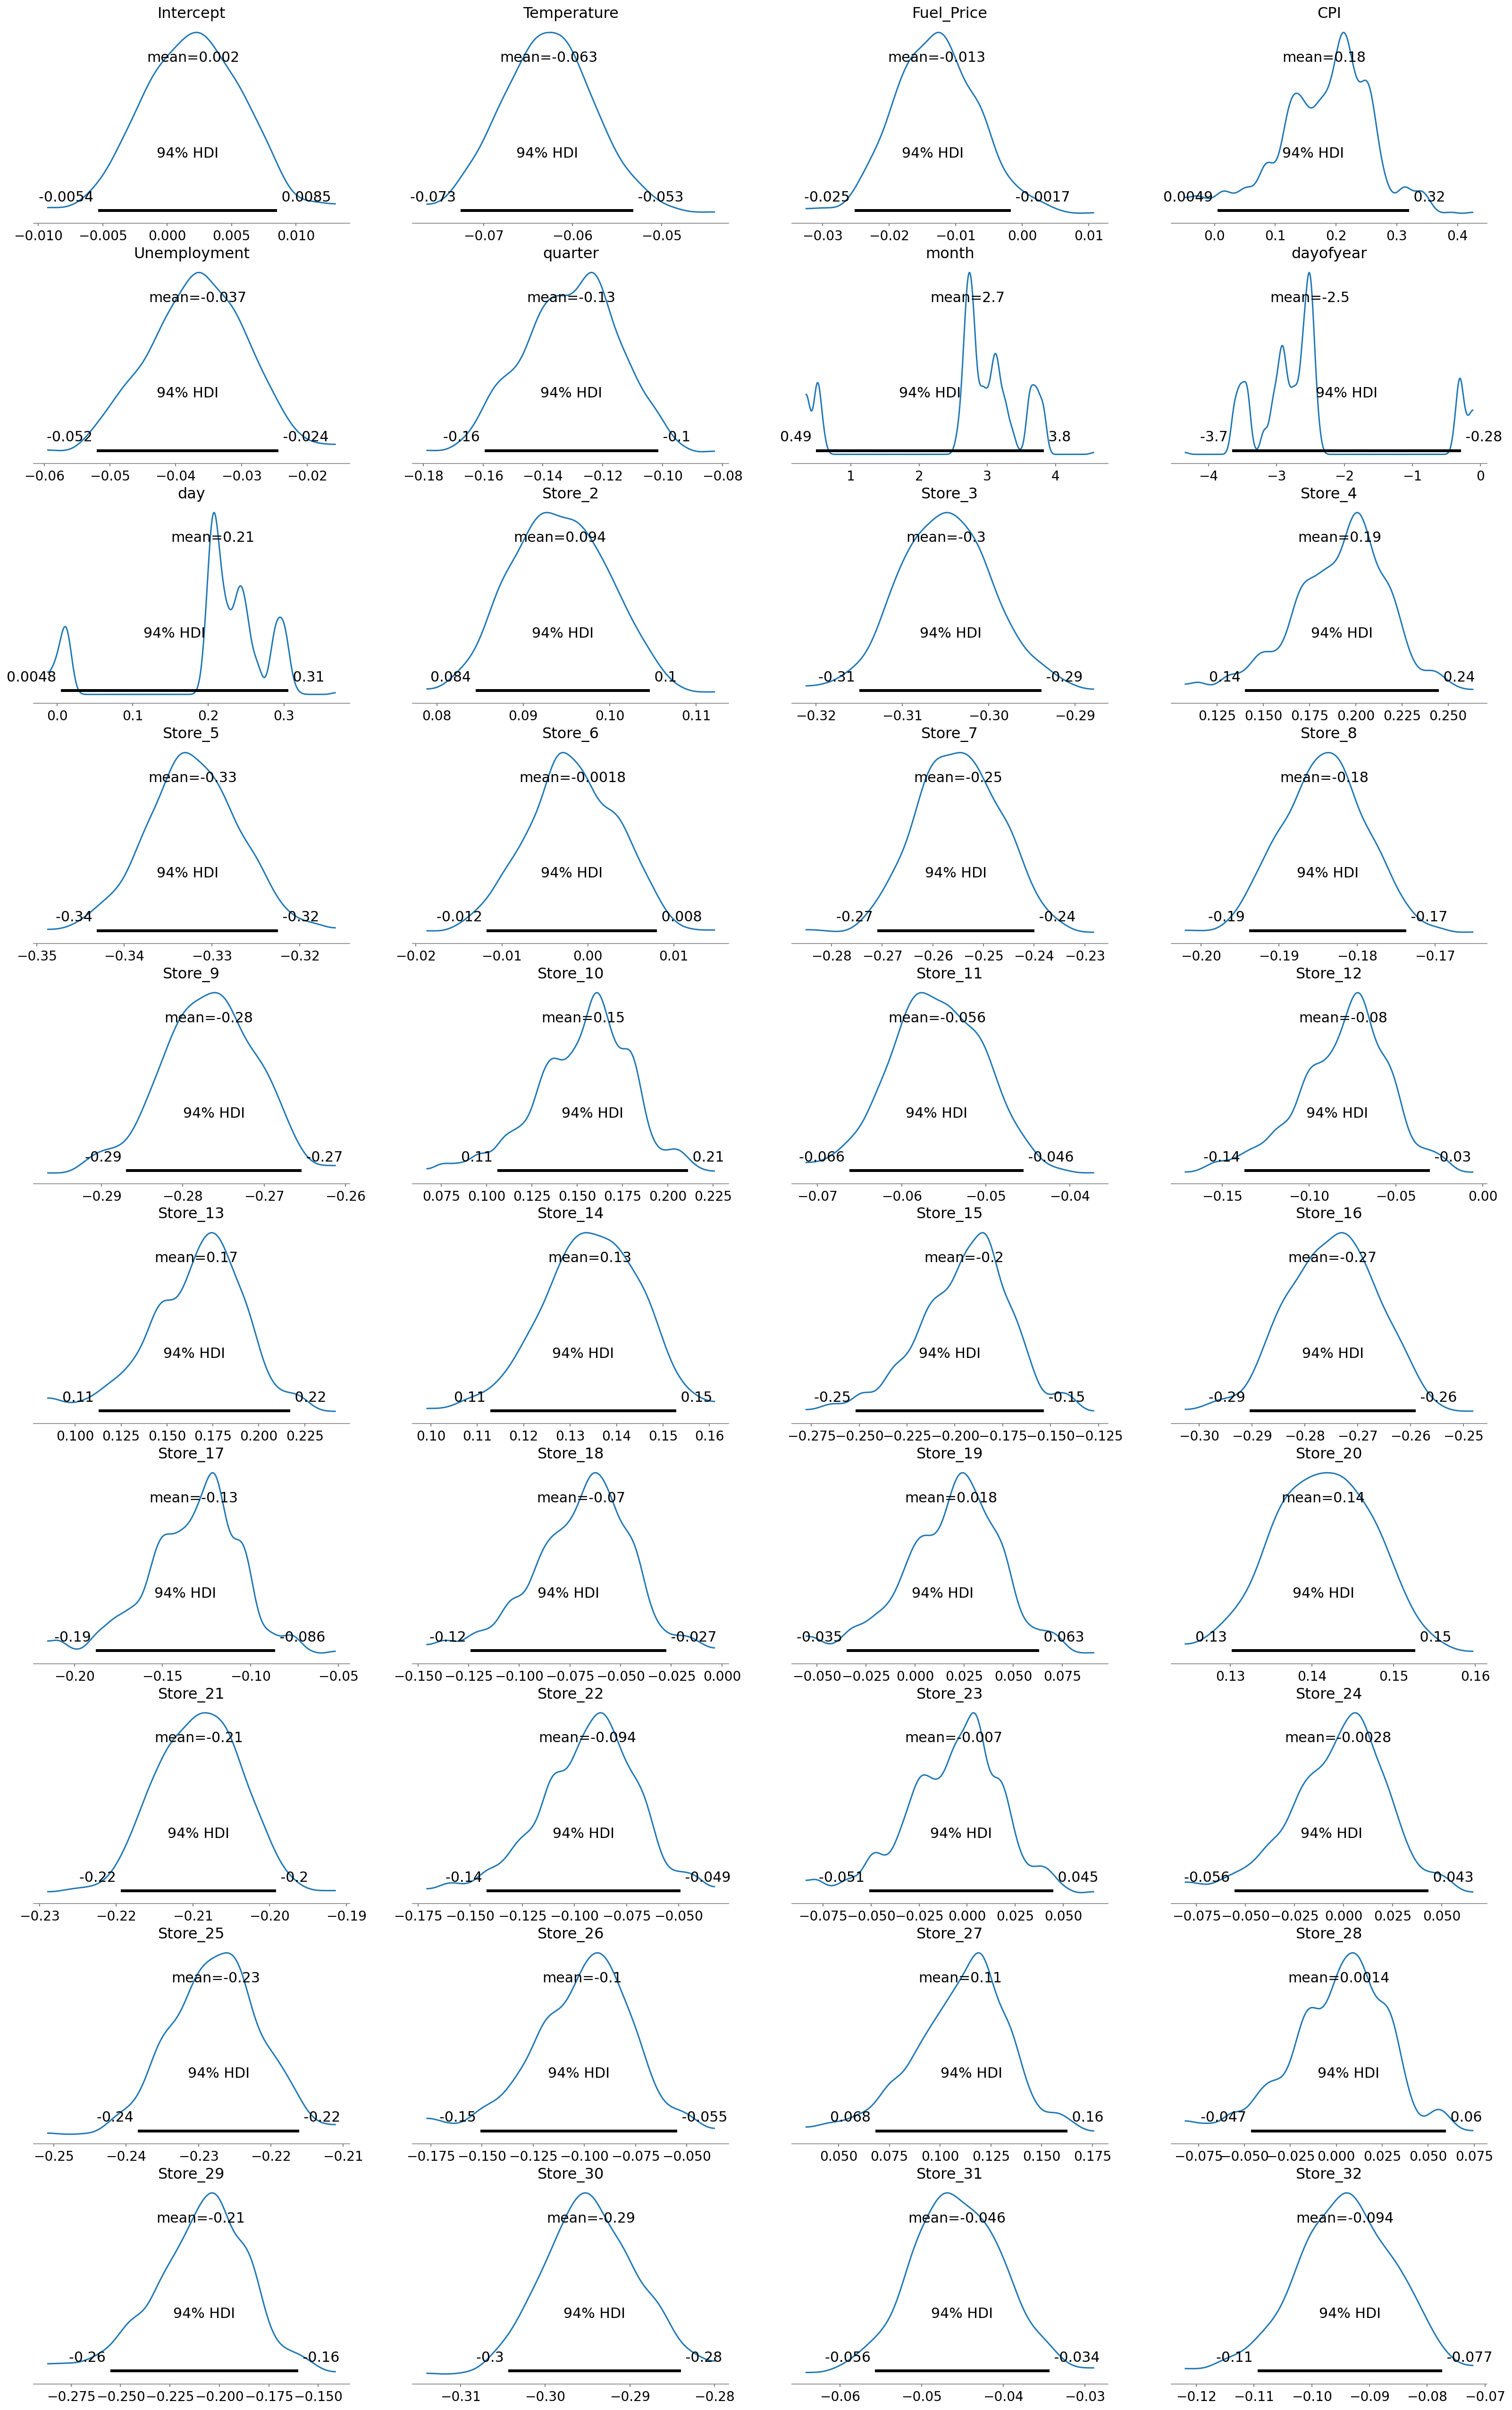

In [ ]:
pm.plot_posterior(trace_log)

In [ ]:
pm.summary(trace_log)


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -0.004  0.014  -0.032    0.022      0.000    0.000    1189.0   
Temperature  -0.062  0.016  -0.091   -0.035      0.001    0.000     888.0   
Fuel_Price   -0.006  0.015  -0.038    0.019      0.001    0.001     884.0   
CPI          -0.083  0.015  -0.110   -0.055      0.001    0.000     868.0   
Unemployment -0.099  0.014  -0.129   -0.075      0.000    0.000    1309.0   
quarter      -0.180  0.054  -0.275   -0.073      0.003    0.002     292.0   
month         1.972  1.650  -0.554    6.085      0.173    0.136      90.0   
dayofyear    -1.715  1.658  -4.864    1.795      0.174    0.139      91.0   
day           0.132  0.147  -0.115    0.478      0.015    0.013      91.0   
sd            0.986  0.009   0.969    1.002      0.000    0.000    1528.0   

              ess_tail  r_hat  
Intercept        592.0    NaN  
Temperature      767.0    NaN  
Fuel_Price       700.0    NaN  
CPI              679.0    NaN  
Unemployment     820.0    NaN  
quarter          294.0    NaN  
month            115.0    NaN  
dayofyear        115.0    NaN  
day              122.0    NaN  
sd               480.0    NaN

<ipython-input-141-2042e0927c2c>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_log)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (55), generating only 20 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3d253280>,
      dtype=object)

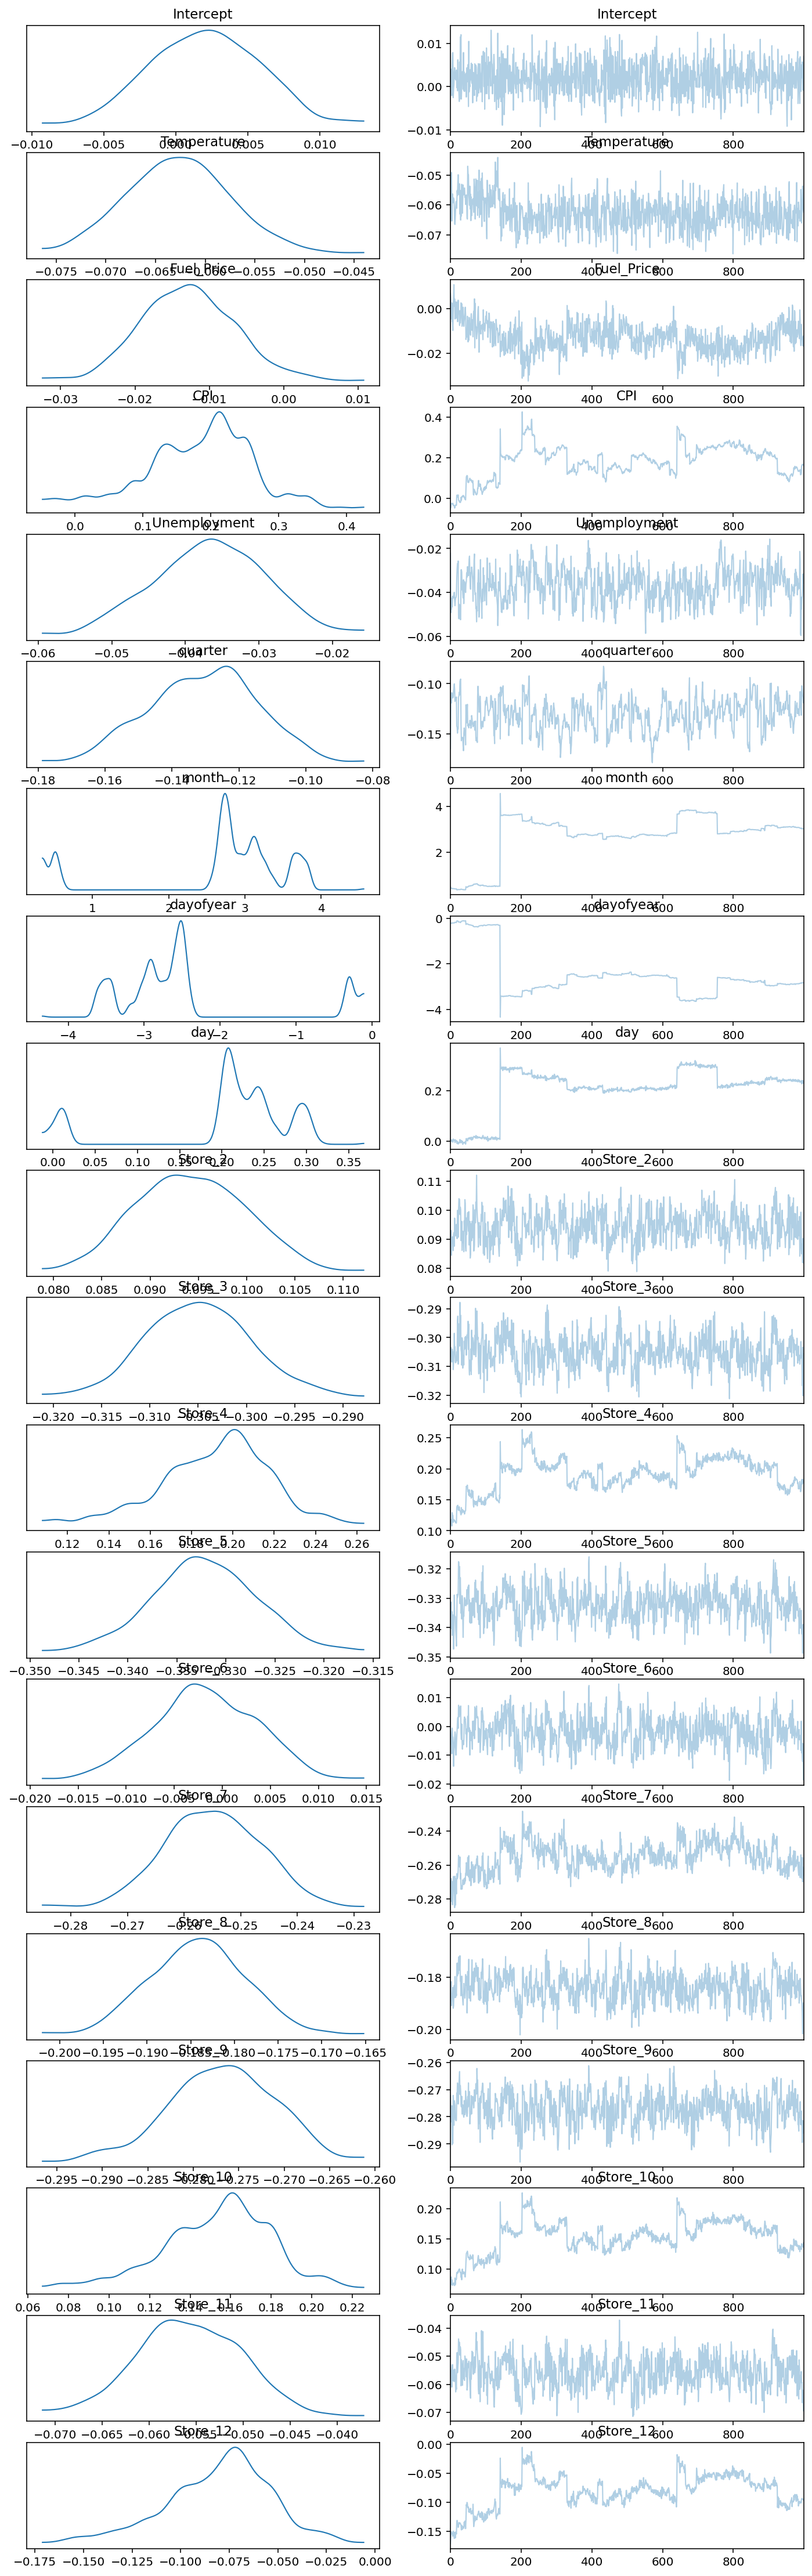

In [ ]:
pm.traceplot(trace_log)

<ipython-input-142-1783ad39caff>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace_log)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3e0f6ca0>],
      dtype=object)

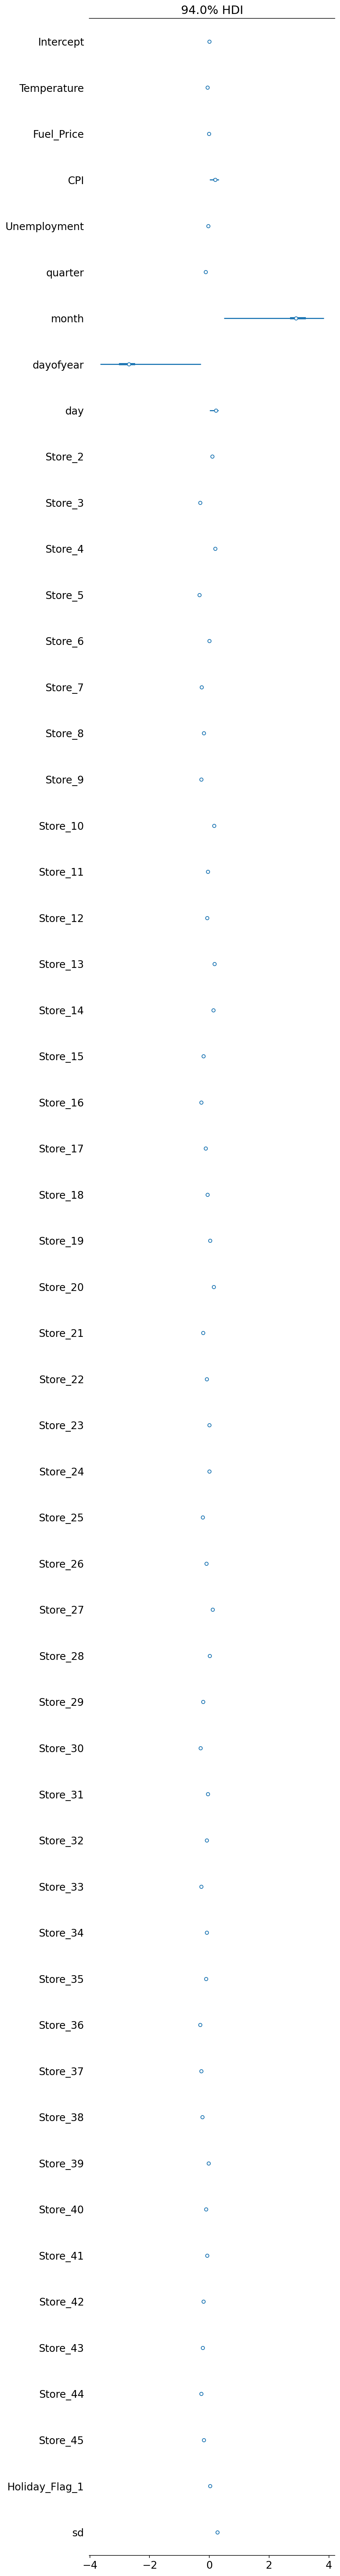

In [ ]:
pm.forestplot(trace_log)

<ipython-input-143-1f772dcd400a>:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  pm.autocorrplot(trace_log)
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.8/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (55) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3d3f95b0>,
      dtype=object)

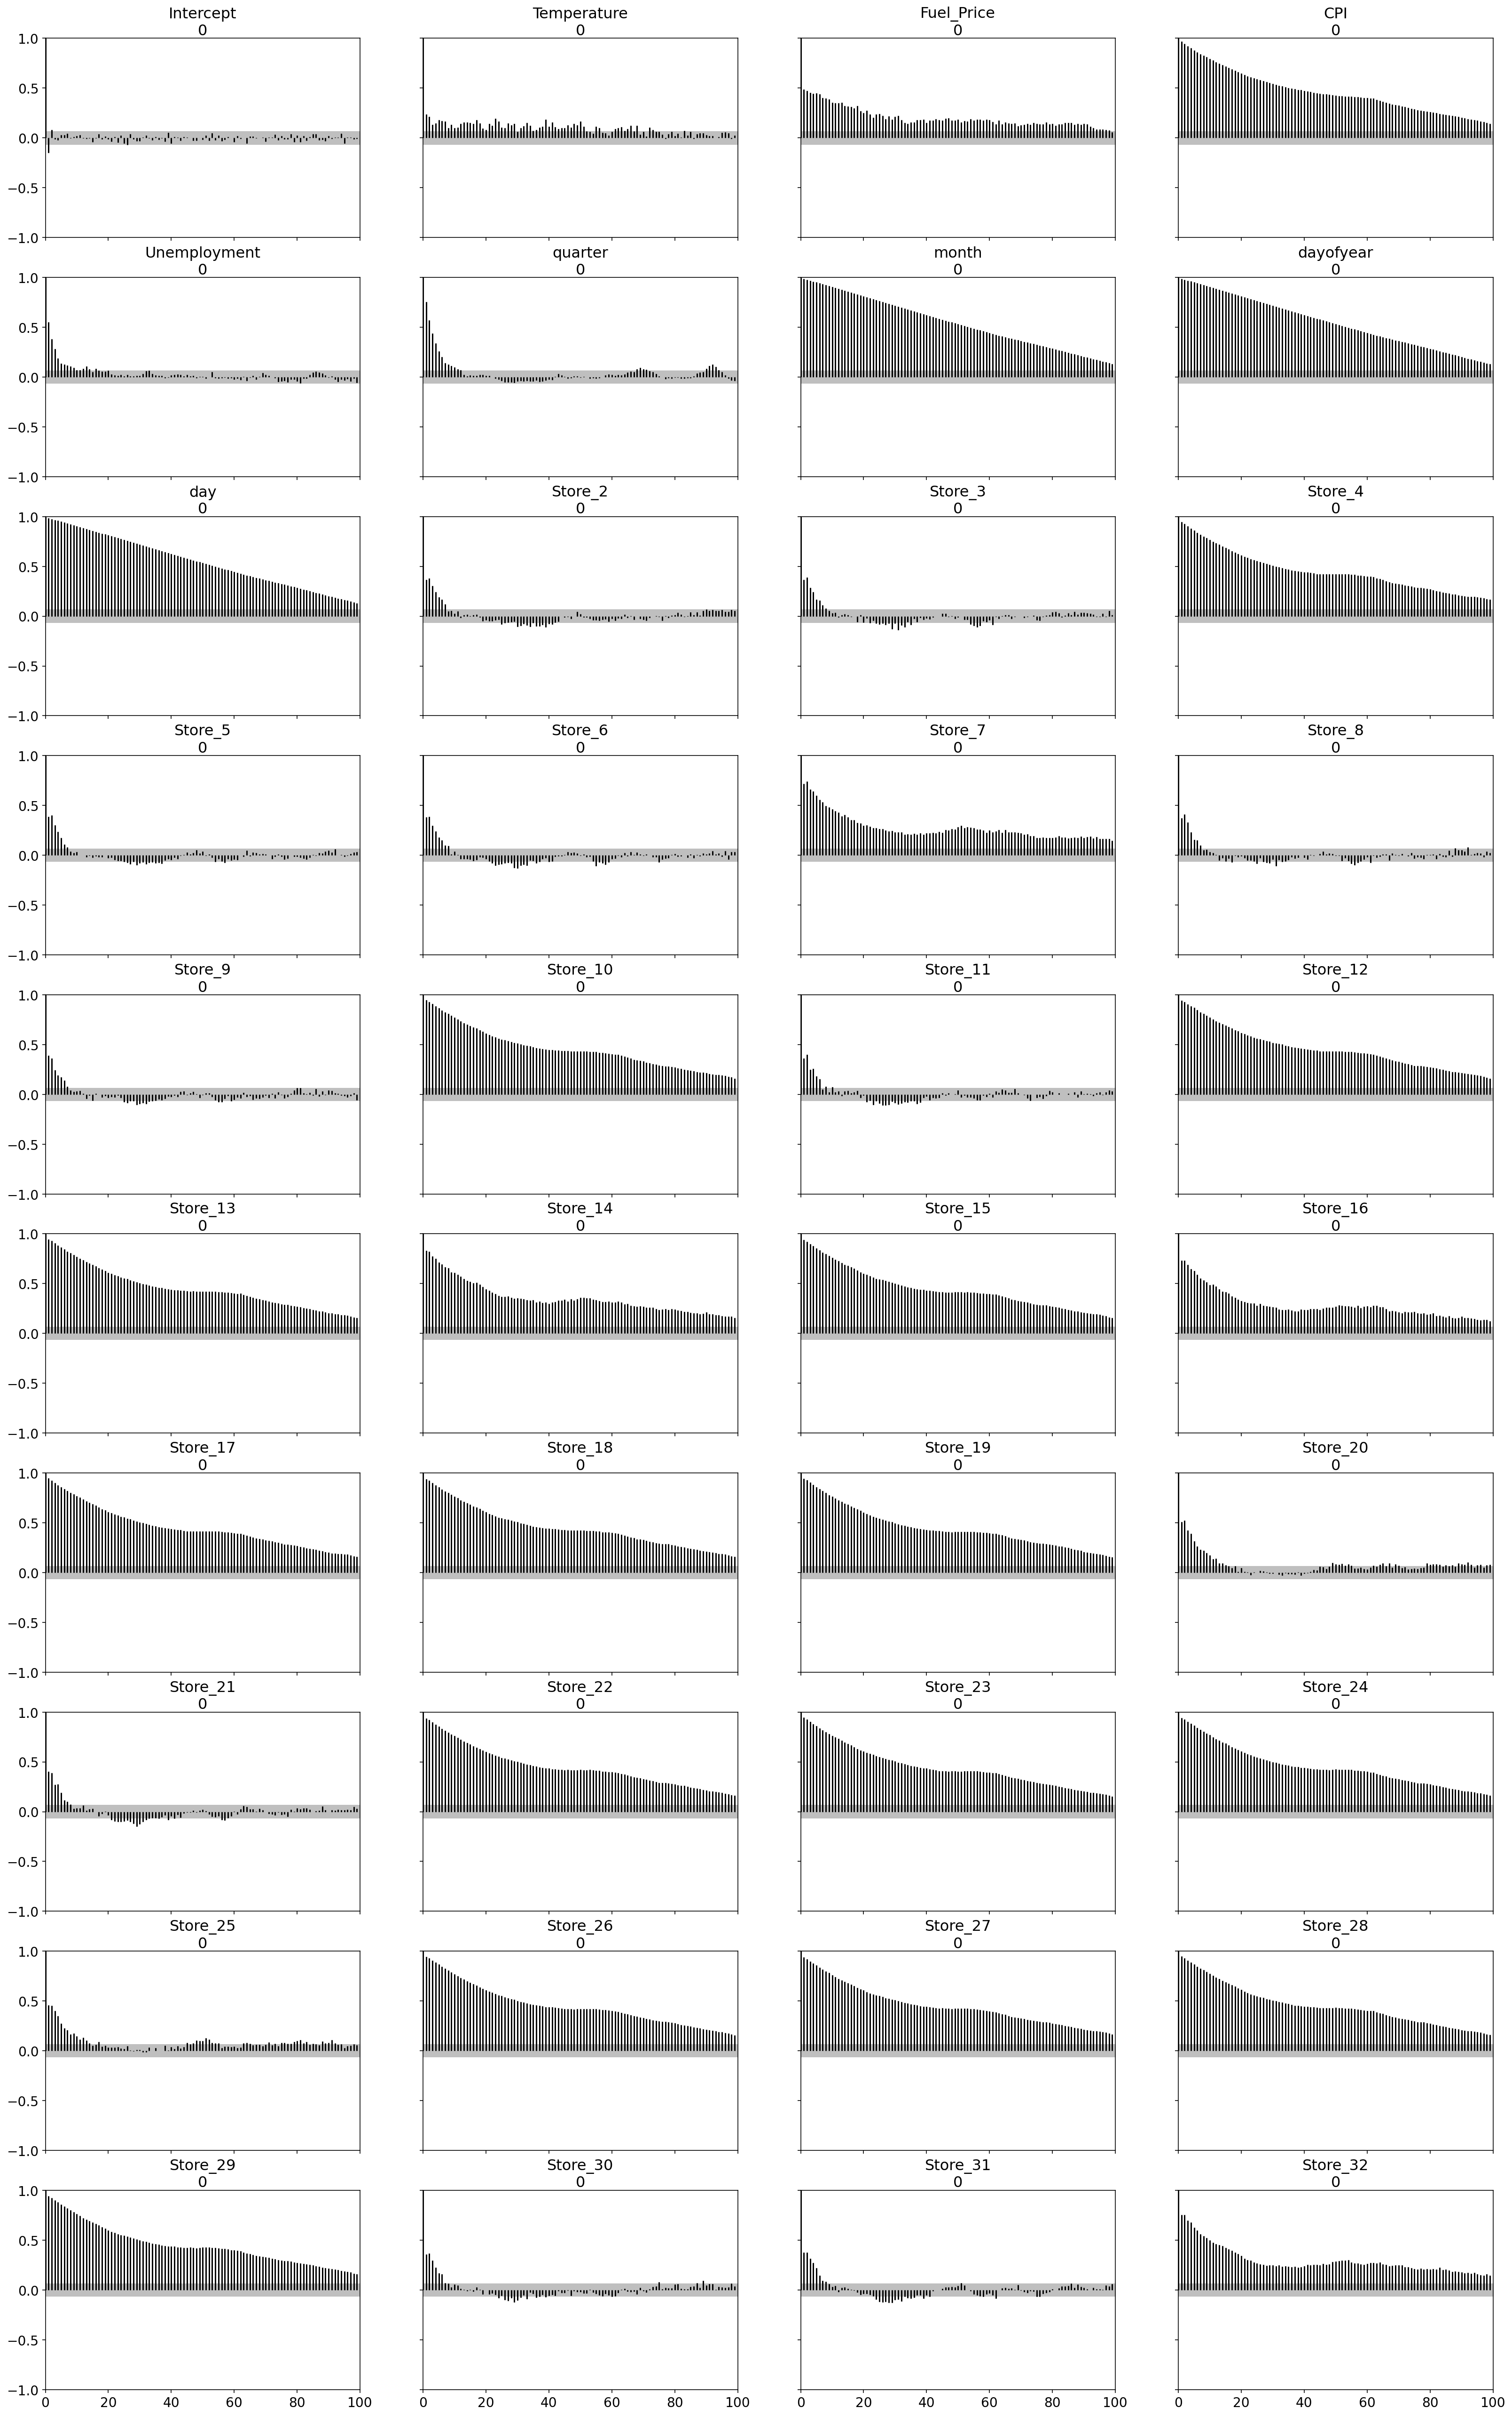

In [ ]:
pm.autocorrplot(trace_log)